# **Supervised Fine Tuning EcoSortify Chatbot with Gemini 2.0 Flash using the Google Gen AI SDK**

## **Overview**

**Gemini** is a family of generative AI models developed by Google DeepMind designed for multimodal use cases. The Gemini API gives you access to the various Gemini models, such as Gemini 2.0 and Gemini 2.0.
This notebook demonstrates fine-tuning the Gemini 2.0 using the Vertex AI Supervised Tuning feature. Supervised Tuning allows you to use your own labeled training data to further refine the base model's capabilities toward your specific tasks.
Supervised Tuning uses labeled examples to tune a model. Each example demonstrates the output you want from your text model during inference.
First, ensure your training data is of high quality, well-labeled, and directly relevant to the target task. This is crucial as low-quality data can adversely affect the performance and introduce bias in the fine-tuned model.
Training: Experiment with different configurations to optimize the model's performance on the target task.
Evaluation:
Metric: Choose appropriate evaluation metrics that accurately reflect the success of the fine-tuned model for your specific task
Evaluation Set: Use a separate set of data to evaluate the model's performance

## **Install the Google Gen AI SDK**

The new Google Gen AI SDK provides a unified interface to Gemini through both the Gemini Developer API and the Gemini API on Vertex AI. With a few exceptions, code that runs on one platform will run on both. This means that you can prototype an application using the Developer API and then migrate the application to Vertex AI without rewriting your code.

In [1]:
%pip install --upgrade --quiet google-cloud-aiplatform google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.3/196.3 kB 13.5 MB/s eta 0:00:00


## **Restart Runtime**

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [2]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## **Authenticate Notebook Environment (Colab Only)**

If you're running this notebook on Google Colab, run the cell below to authenticate your environment.

In [3]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

## **Set the Google Cloud Project  and Initialize the Google Gen AI SDK**

To get started using Vertex AI, you must have an existing Google Cloud project and enable the Vertex AI API.

In [1]:
import os

from google import genai
from google.genai import types

PROJECT_ID = "ecosortify-459004"
LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)

## **Import Libraries**

By importing these, you gain access to the necessary tools for generating data and interacting with the base model.

In [2]:
import json
import random
import requests
import re

# Vertex AI SDK
import vertexai
from google.cloud import aiplatform
from google.cloud.aiplatform.metadata import context
from google.cloud.aiplatform.metadata import utils as metadata_utils
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Data manipulation
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
from wordcloud import WordCloud

vertexai.init(project=PROJECT_ID, location=LOCATION)

## **Data Understanding**

To optimize the supervised fine-tuning process for a foundation model, ensure your dataset includes examples that reflect the desired task. Each record in the dataset pairs an input text (or prompt) with its corresponding expected output. This supervised tuning approach uses the dataset to effectively teach the model the specific behavior or task you need it to perform, by providing numerous illustrative examples.

The size of your dataset will vary depending on the complexity of the task, but as a general rule, the more examples you include, the better the model's performance. For fine-tuning Gemini on Vertex AI, the minimum number of examples are 100.

### **Dataset Format**

Your training data should be structured in a JSONL file and stored at a Google Cloud Storage (GCS) URI.  Each line in the JSONL file must adhere to the following schema:

A `contents` array containing objects that define:
- A `role` ("user" for user input or "model" for model output)
- `parts` containing the input data.

```json
{
   "contents":[
      {
         "role":"user",  # This indicate input content
         "parts":[
            {
               "text":"How are you?"
            }
         ]
      },
      {
         "role":"model", # This indicate target content
         "parts":[ # text only
            {
               "text":"I am good, thank you!"
            }
         ]
      }
      #  ... repeat "user", "model" for multi turns.
   ]
}
```

### **Dataset Description**

#### **Load The Datasets**

In [3]:
!gsutil cp gs://ecosortify-assets/qna-pairs/raw_knlh_qna_pairs.csv .
!gsutil cp gs://ecosortify-assets/qna-pairs/raw_guide1_qna_pairs.csv .
!gsutil cp gs://ecosortify-assets/qna-pairs/raw_guide2_qna_pairs.csv .
!gsutil cp gs://ecosortify-assets/qna-pairs/raw_ospsp_qna_pairs.csv .
!gsutil cp gs://ecosortify-assets/qna-pairs/preprocessed_qna_pairs.jsonl .

Copying gs://ecosortify-assets/qna-pairs/raw_knlh_qna_pairs.csv...
- [1 files][ 59.8 KiB/ 59.8 KiB]                                                
Operation completed over 1 objects/59.8 KiB.                                     
Copying gs://ecosortify-assets/qna-pairs/raw_guide1_qna_pairs.csv...
- [1 files][ 45.9 KiB/ 45.9 KiB]                                                
Operation completed over 1 objects/45.9 KiB.                                     
Copying gs://ecosortify-assets/qna-pairs/raw_guide2_qna_pairs.csv...
- [1 files][ 28.5 KiB/ 28.5 KiB]                                                
Operation completed over 1 objects/28.5 KiB.                                     
Copying gs://ecosortify-assets/qna-pairs/raw_ospsp_qna_pairs.csv...
- [1 files][125.9 KiB/125.9 KiB]                                                
Operation completed over 1 objects/125.9 KiB.                                    
Copying gs://ecosortify-assets/qna-pairs/preprocessed_qna_pairs.jsonl...
- 

#### **QnA Pairs from "Panduan Parktis Pemilahan Sampah dari Kementrian Negara Lingkungan Hidup RI 2008"**

In [4]:
knlh_df = pd.read_csv('raw_knlh_qna_pairs.csv')
knlh_df

,question,answer
0,Halo! Bisa bantu jelaskan kenapa sih pengelola...,"Halo juga! Jadi begini, pengelolaan sampah di ..."
1,Apa saja sih dampak buruknya kalau sampah ngga...,"Wah, kalau sampah nggak diurus dengan benar, d..."
2,Aku dengar katanya pengelolaan sampah yang ada...,"Iya, sayangnya seringkali begitu. Pengelolaan ..."
3,"Kalau TPA sendiri, biasanya masalah lingkungan...","Nah, TPA itu juga punya tantangan sendiri. Ban..."
4,Kenapa sih pemilahan sampah itu penting banget...,"Penting banget, lho! Dengan kita memilah sampa..."
...,...,...
158,Apa yang dimaksud 'menjaga kondisi alur daur u...,"Maksudnya, pemerintah harus memastikan bahwa k..."
159,Apa saja 'stakeholder terkait' yang perlu dili...,Stakeholder terkait itu banyak pihak[cite: 139...
160,Mengapa memulai daur ulang dari 'ukuran kecil ...,Memulai dari skala kecil atau pilot project it...
161,Apa saja contoh 'sarana/prasarana penunjang' y...,Contohnya bisa berupa penyediaan wadah atau ka...


#### **QnA Pairs from "Dokumen EcoSortify Guide Part 1"**

In [5]:
guide1_df = pd.read_csv('raw_guide1_qna_pairs.csv')
guide1_df

,question,answer
0,Apa yang terjadi pada materi menurut hukum kek...,"Menurut hukum kekekalan materi, materi tidak d..."
1,Kapan sebuah benda yang diproduksi untuk kebut...,Sebuah benda berubah menjadi sampah ketika ia ...
2,Mengapa sampah dianggap sebagai material yang ...,Sampah dianggap demikian karena dalam konteks ...
3,Faktor apa yang mempercepat terbentuknya sampa...,Pola konsumsi dan produksi manusia yang terus ...
4,Apakah benda yang dibuang oleh manusia benar-b...,"Tidak, ketika manusia membuang sesuatu, benda ..."
...,...,...
173,"Apa dampak dari tidak terkelolanya 22,3 juta t...","Tidak terkelolanya 22,3 juta ton sampah terseb..."
174,Mengapa rendahnya kesadaran masyarakat menjadi...,Karena jika masyarakat tidak sadar akan pentin...
175,"Jika sampah tidak dipilah dari rumah, apa yang...","Jika tidak dipilah dari rumah, material daur u..."
176,Apa bahaya utama dari gas dioksin dan furan ya...,Dioksin dan furan adalah senyawa kimia yang sa...


#### **QnA Pairs from "Dokumen EcoSortify Guide Part 2"**

In [6]:
guide2_df = pd.read_csv('raw_guide2_qna_pairs.csv')
guide2_df

,question,answer
0,Benarkah anggapan bahwa sampah organik selalu ...,Tidak sepenuhnya benar. Meskipun sampah organi...
1,Apakah bank sampah hanya ditujukan untuk orang...,"Tidak, bank sampah bukan soal ekonomi semata, ..."
2,Apa saja manfaat berpartisipasi di bank sampah...,"Selain bisa menabung dari sampah, bank sampah ..."
3,Benarkah mitos bahwa sampah daur ulang yang su...,Ini hanya terjadi jika pemilahan sampah tidak ...
4,Apa yang terjadi jika sampah daur ulang tercam...,Jika sampah daur ulang tercampur dengan sampah...
...,...,...
122,Ke mana sampah B3 rumah tangga sebaiknya diset...,Beberapa kota menyediakan TPS khusus untuk lim...
123,Bagaimana penanganan sampah B3 dalam jumlah be...,"Untuk jumlah besar, wajib menggunakan jasa pen..."
124,Sebutkan hal-hal yang tidak boleh dilakukan te...,"Jangan membuang baterai ke tong sampah biasa, ..."
125,Upaya apa saja yang bisa dilakukan untuk mengu...,"Gunakan baterai isi ulang (rechargeable), kura..."


#### **QnA Pairs from "Ebook OSPSP (Tentang Teori Pengelolaan Sampah Perkotaan)"**

In [7]:
ospsp_df = pd.read_csv('raw_ospsp_qna_pairs.csv')
ospsp_df

,question,answer
0,Siapa saja pihak yang perlu memberikan perhati...,Pengelolaan sampah perkotaan adalah isu pentin...
1,Faktor apa yang menyebabkan volume sampah di a...,Seiring dengan pertumbuhan populasi dan perkem...
2,"Selain proses pengumpulan, transportasi, dan p...",Pengelolaan sampah perkotaan yang efektif dan ...
3,Aspek apa saja yang menjadi pertimbangan penti...,"Selain itu, isu-isu terkait lingkungan, keseha..."
4,Apa yang diperlukan untuk mewujudkan pengelola...,Untuk mewujudkan pengelolaan sampah perkotaan ...
...,...,...
582,Siapa saja yang perlu dilibatkan dalam upaya k...,"Berbagai pihak, seperti pemerintah, masyarakat..."
583,Apa peran pemerintah dalam mendorong pengelola...,Perlu merumuskan kebijakan dan regulasi yang t...
584,Apa peran masyarakat dalam pengelolaan sampah ...,Perlu meningkatkan kesadaran dan partisipasiny...
585,Bagaimana sektor swasta dapat berperan dalam s...,Dapat berperan dalam menyediakan teknologi dan...


#### **Sample Preprocessed JSON Line file from QnA Pairs**

In [8]:
with open('preprocessed_qna_pairs.jsonl', 'r') as file:
    for line in file:
        data = json.loads(line)
        print(json.dumps(data))

{"contents": [{"role": "user", "parts": [{"text": "Mengapa pengelolaan sampah di kota-kota besar seringkali masih menjadi masalah yang sulit dikendalikan?"}]}, {"role": "model", "parts": [{"text": "Tentu! Pengelolaan sampah di kota besar jadi rumit karena beberapa faktor nih. Pertama, jumlah penduduk dan kegiatan ekonomi yang terus meningkat bikin volume sampah juga makin banyak. Kedua, timbulan sampah yang nggak terkendali ini bisa jadi konsekuensi dari aktivitas manusia dan industri. Nah, ini kemudian berdampak ke lingkungan perkotaan, seperti masalah keindahan, kesehatan masyarakat, bahkan bisa memicu bencana kayak ledakan gas metan atau tanah longsor."}]}, {"role": "user", "parts": [{"text": "Apa fokus utama pengelolaan sampah yang umumnya dilakukan oleh dinas terkait saat ini?"}]}, {"role": "model", "parts": [{"text": "Jadi begini, pengelolaan sampah yang diselenggarakan oleh dinas terkait itu kebanyakan masih fokus pada pengumpulan dan pengangkutan sampah langsung ke Tempat Pemro

### **Exploratory Data Analysis**

#### **Checking Missing Values**

In [9]:
print("Missing values di knlh_df:")
print(knlh_df.isnull().sum())

print("\nMissing values di guide1_df:")
print(guide1_df.isnull().sum())

print("\nMissing values di guide2_df:")
print(guide2_df.isnull().sum())

print("\nMissing values di ospsp_df:")
print(ospsp_df.isnull().sum())

Missing values di knlh_df:
question    0
answer      0
dtype: int64

Missing values di guide1_df:
question    0
answer      0
dtype: int64

Missing values di guide2_df:
question    0
answer      0
dtype: int64

Missing values di ospsp_df:
question    0
answer      0
dtype: int64


#### **Text Length Distribution**

In [10]:
def plot_text_length_distribution(df):
    """
    Plots the distribution of question and answer lengths in a DataFrame.

    Args:
      df: A pandas DataFrame with 'question' and 'answer' columns.
    """
    df['question_length'] = df['question'].apply(lambda x: len(str(x).split()))
    df['answer_length'] = df['answer'].apply(lambda x: len(str(x).split()))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df['question_length'], bins=30, kde=True)
    plt.title('Distribusi Panjang Pertanyaan (dalam kata)')

    plt.subplot(1, 2, 2)
    sns.histplot(df['answer_length'], bins=30, kde=True, color='orange')
    plt.title('Distribusi Panjang Jawaban (dalam kata)')

    plt.tight_layout()
    plt.show()

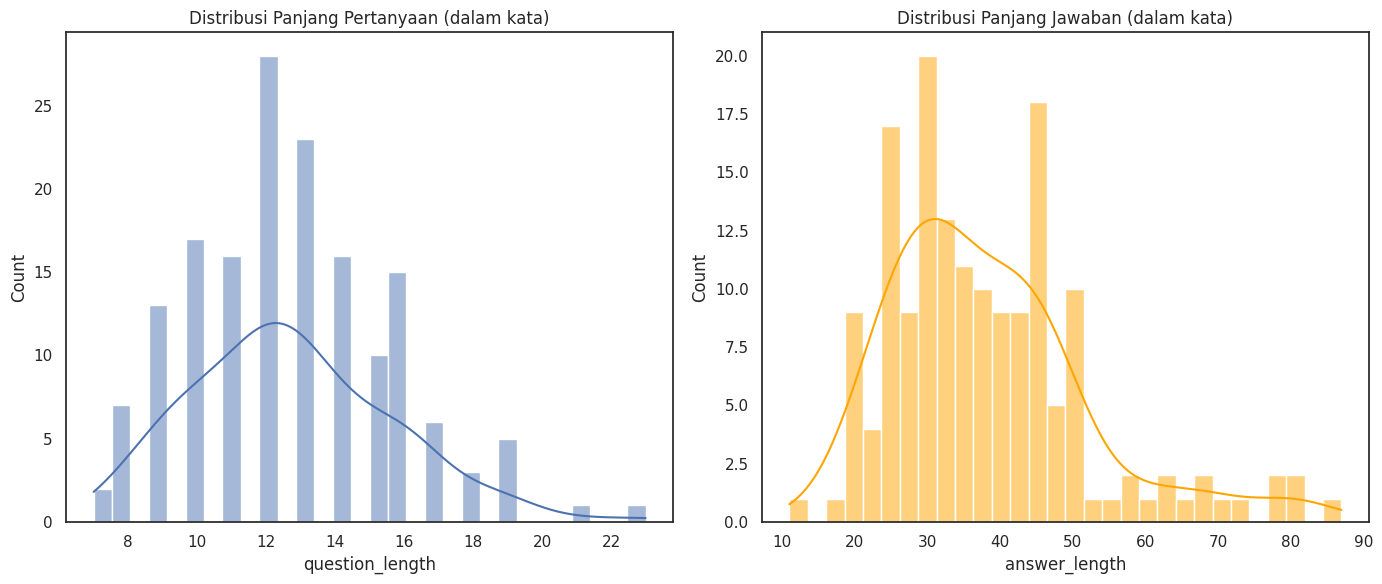

In [11]:
plot_text_length_distribution(knlh_df)

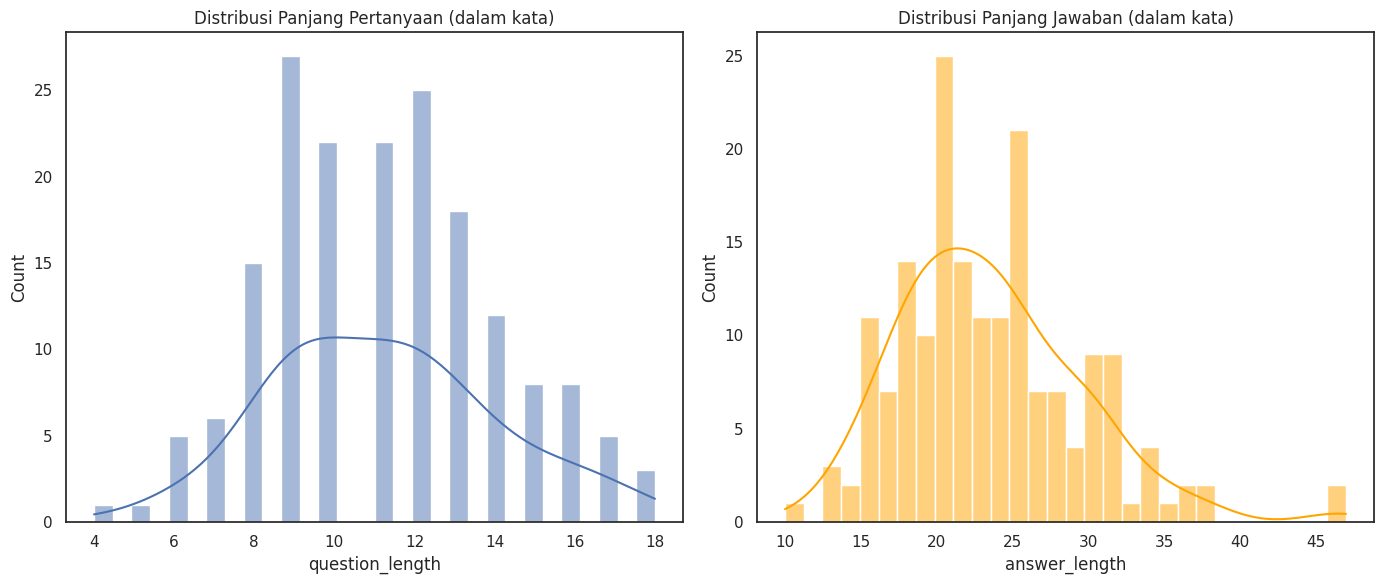

In [12]:
plot_text_length_distribution(guide1_df)

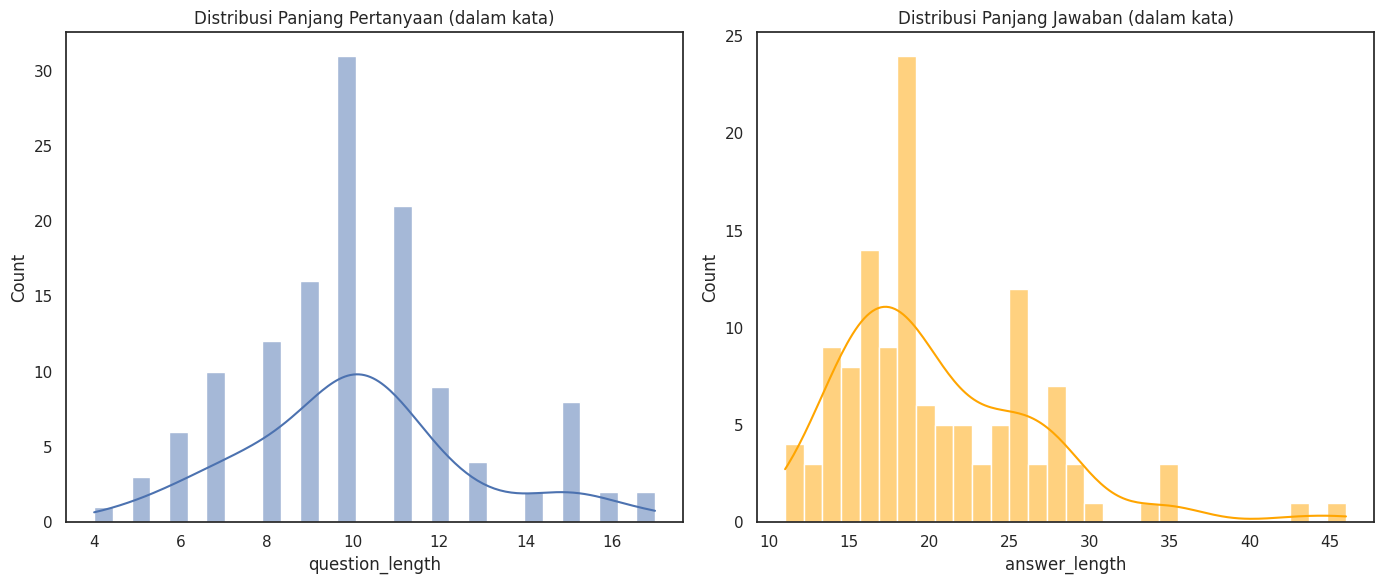

In [13]:
plot_text_length_distribution(guide2_df)

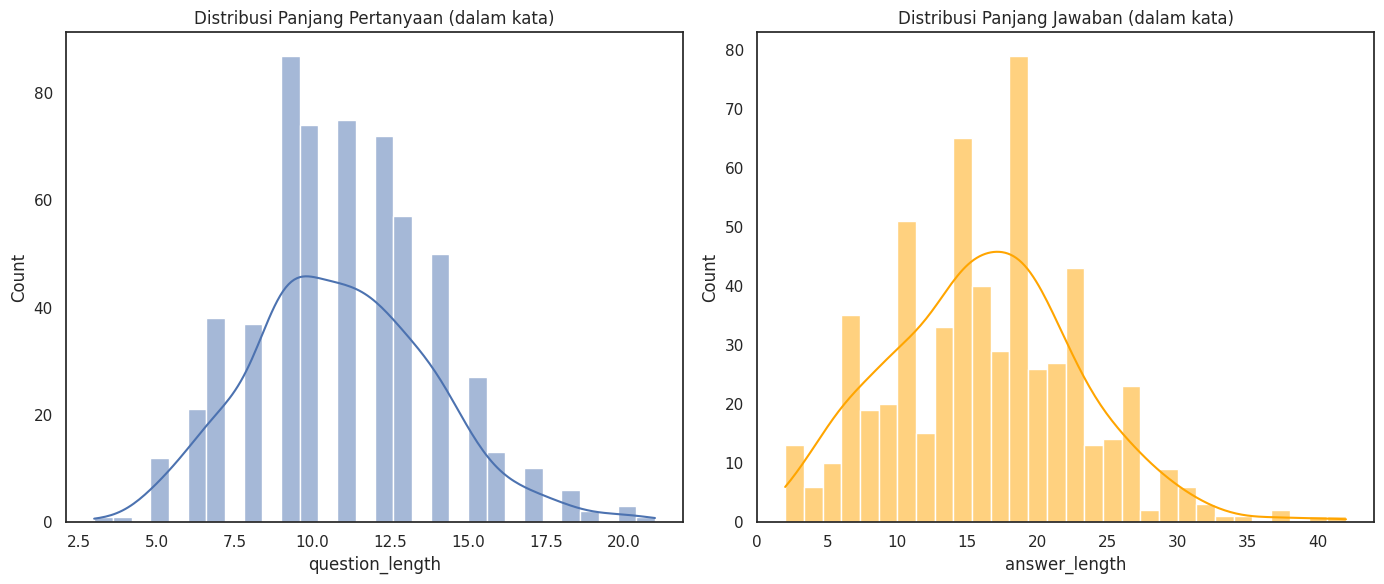

In [14]:
plot_text_length_distribution(ospsp_df)

#### **Wordcloud Combined All Pairs**

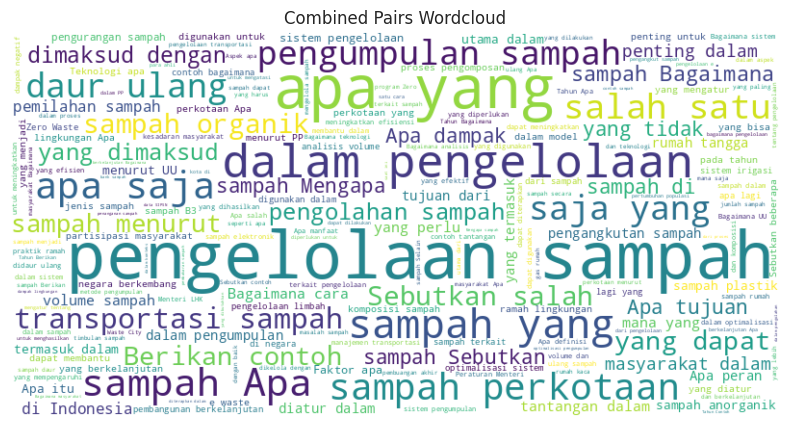

In [15]:
text = ' '.join(knlh_df['question'].dropna()).join(knlh_df['answer'].dropna())
text += ' '.join(guide1_df['question'].dropna()).join(guide1_df['answer'].dropna())
text += ' '.join(guide2_df['question'].dropna()).join(guide2_df['answer'].dropna())
text += ' '.join(ospsp_df['question'].dropna()).join(ospsp_df['answer'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Combined Pairs Wordcloud")
plt.show()

#### **Question Type Frequency**

In [16]:
combined_df = pd.concat([knlh_df, guide1_df, guide2_df, ospsp_df], ignore_index=True)
combined_df['question'].str.lower().str.extract(r'^(\w+)').value_counts()[:11]

,count
0,
apa,292
bagaimana,169
mengapa,85
sebutkan,85
berikan,38
selain,30
apakah,26
berapa,24
menurut,19


### **Data Preprocessing**

#### **Text Cleaning**

In [17]:
guide1_df.sample()['answer'].values[0]

'Limbah infeksius adalah sampah yang terkontaminasi oleh patogen atau mikroorganisme penyebab penyakit, contohnya perban bekas, kapas darah, sarung tangan bekas, jarum suntik, dan APD yang sudah digunakan[cite: 124, 125].'

In [18]:
def check_citations_sum(df):
    df['has_citation'] = df['answer'].str.contains('\s*\[cite:\s*\d+\]', regex=True)
    citation_count_sum = df['has_citation'].sum()
    return citation_count_sum

check_citations_sum(combined_df)

np.int64(829)

In [19]:
def clean_citations(text):
    cleaned_text = re.sub(r'\s*\[cite:\s*\d+\]', '', text)
    return cleaned_text

In [20]:
combined_df['answer'] = combined_df['answer'].apply(clean_citations)
check_citations_sum(combined_df)

np.int64(0)

In [21]:
combined_df.drop(['question_length', 'answer_length', 'has_citation'], axis=1, inplace=True)
combined_df

,question,answer
0,Halo! Bisa bantu jelaskan kenapa sih pengelola...,"Halo juga! Jadi begini, pengelolaan sampah di ..."
1,Apa saja sih dampak buruknya kalau sampah ngga...,"Wah, kalau sampah nggak diurus dengan benar, d..."
2,Aku dengar katanya pengelolaan sampah yang ada...,"Iya, sayangnya seringkali begitu. Pengelolaan ..."
3,"Kalau TPA sendiri, biasanya masalah lingkungan...","Nah, TPA itu juga punya tantangan sendiri. Ban..."
4,Kenapa sih pemilahan sampah itu penting banget...,"Penting banget, lho! Dengan kita memilah sampa..."
...,...,...
1050,Siapa saja yang perlu dilibatkan dalam upaya k...,"Berbagai pihak, seperti pemerintah, masyarakat..."
1051,Apa peran pemerintah dalam mendorong pengelola...,Perlu merumuskan kebijakan dan regulasi yang t...
1052,Apa peran masyarakat dalam pengelolaan sampah ...,Perlu meningkatkan kesadaran dan partisipasiny...
1053,Bagaimana sektor swasta dapat berperan dalam s...,Dapat berperan dalam menyediakan teknologi dan...


#### **Convert to JSON Line Format**

In [22]:
data = []
with open('preprocessed_qna_pairs.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

extracted_questions = []
extracted_answers = []
qna_data = []
for item in data:
    for content_block in item['contents']:
        if content_block['role'] == 'user':
            extracted_questions.append(content_block['parts'][0]['text'])
        elif content_block['role'] == 'model':
            extracted_answers.append(content_block['parts'][0]['text'])

extracted_preprocessed_df = pd.DataFrame({
    'question': extracted_questions,
    'answer': extracted_answers
})

In [23]:
all_combined_df = pd.concat([combined_df, extracted_preprocessed_df], ignore_index=True)
all_combined_df

,question,answer
0,Halo! Bisa bantu jelaskan kenapa sih pengelola...,"Halo juga! Jadi begini, pengelolaan sampah di ..."
1,Apa saja sih dampak buruknya kalau sampah ngga...,"Wah, kalau sampah nggak diurus dengan benar, d..."
2,Aku dengar katanya pengelolaan sampah yang ada...,"Iya, sayangnya seringkali begitu. Pengelolaan ..."
3,"Kalau TPA sendiri, biasanya masalah lingkungan...","Nah, TPA itu juga punya tantangan sendiri. Ban..."
4,Kenapa sih pemilahan sampah itu penting banget...,"Penting banget, lho! Dengan kita memilah sampa..."
...,...,...
1498,"Dalam konteks Zero Waste, mengapa ""Recycle"" di...",Karena 'Recycle' itu masih butuh energi dan su...
1499,Apa perbedaan mendasar antara gaya hidup Eco-L...,"Eco-Living itu payung besarnya, mencakup semua..."
1500,Apa perbedaan utama antara proses dekomposisi ...,Perbedaan utamanya ada di kebutuhan oksigen. K...
1501,Bagaimana pemanfaatan sampah organik menjadi k...,Keduanya sangat mendukung! Kompos menyediakan ...


In [24]:
system_instruction = f"""Kamu adalah AI yang mengkhususkan diri dalam menjawab pertanyaan seputar edukasi pengetahuan dan pemilahan sampah. Tujuan kamu adalah memberikan jawaban yang edukatif, jelas, dan mudah dipahami oleh pengguna umum dalam bahasa Indonesia.
Jawaban kamu harus berbobot dan komprehensif, tetapi tetap ringkas dan tidak terlalu kaku atau terlalu formal. Gunakan gaya bahasa yang ramah, khas seperti chatbot yang siap membantu pengguna.
Gunakan konteks dari pertanyaan yang saya berikan untuk memberikan jawaban terbaik. Jawaban tidak perlu terlalu panjang, tapi harus mengandung informasi yang akurat dan bermanfaat.
Jika saya memberikan pertanyaan, cukup jawab langsung sesuai instruksi di atas. Tapi jika diperlukan, berikan tambahan penjelasan atau format khusus lainnya.
"""

In [25]:
def df_to_jsonl(df, output_file):
    """Converts a Pandas DataFrame to JSONL format and saves it to a file.

    Args:
      df: The DataFrame to convert.
      output_file: The name of the output file.
    """

    with open(output_file, "w") as f:
        for row in df.itertuples(index=False):
            jsonl_obj = {
                "systemInstruction": {"parts": [{"text": f"{system_instruction}"}]},
                "contents": [
                    {
                        "role": "user",
                        "parts": [{"text": f"{row.question}"}],
                    },
                    {"role": "model", "parts": [{"text": row.answer}]},
                ],
            }
            f.write(json.dumps(jsonl_obj) + "\n")

df_to_jsonl(all_combined_df, "all_combined_pairs.jsonl")

In [26]:
!gsutil cp ./all_combined_pairs.jsonl gs://ecosortify-assets/qna-pairs/

Copying file://./all_combined_pairs.jsonl [Content-Type=application/octet-stream]...
|
Operation completed over 1 objects/1.7 MiB.                                      


## **Fine Tuning**

### **Setup Dataset Source**

In [27]:
gemini_base_model = "gemini-2.0-flash-001"

In [28]:
train_dataset = "gs://ecosortify-assets/qna-pairs/all_combined_pairs.jsonl"

training_dataset = {
    "gcs_uri": train_dataset,
}

# validation_dataset = f"""{BUCKET_URI}/squad_train.jsonl"""
# validation_dataset = types.TuningValidationDataset(gcs_uri=validation_dataset)

### **Hyperparameter Tuning**

In [29]:
tuning_config=types.CreateTuningJobConfig(
    adapter_size="ADAPTER_SIZE_EIGHT",
    epoch_count=1,  # set to one to keep time and cost low
    tuned_model_display_name="sortibot-qa-0.1beta",
),

### **Start Fine Tuning Jobs**

In [30]:
sft_tuning_job = client.tunings.tune(
    base_model=gemini_base_model,
    training_dataset=training_dataset,
    config=types.CreateTuningJobConfig(
        adapter_size="ADAPTER_SIZE_EIGHT",
        epoch_count=1,  # set to one to keep time and cost low
        tuned_model_display_name="sortibot-qa-1.0beta",
    ),
)
sft_tuning_job

<ipython-input-30-bf89bee273de>:1: ExperimentalWarning: The SDK's tuning implementation is experimental, and may change in future versions.
  sft_tuning_job = client.tunings.tune(


TuningJob(name='projects/838338694702/locations/us-central1/tuningJobs/1994857569910259712', state=<JobState.JOB_STATE_PENDING: 'JOB_STATE_PENDING'>, create_time=datetime.datetime(2025, 5, 25, 10, 32, 57, 146598, tzinfo=TzInfo(UTC)), start_time=None, end_time=None, update_time=datetime.datetime(2025, 5, 25, 10, 32, 57, 146598, tzinfo=TzInfo(UTC)), error=None, description=None, base_model='gemini-2.0-flash-001', tuned_model=None, supervised_tuning_spec=SupervisedTuningSpec(hyper_parameters=SupervisedHyperParameters(adapter_size=<AdapterSize.ADAPTER_SIZE_EIGHT: 'ADAPTER_SIZE_EIGHT'>, epoch_count=1, learning_rate_multiplier=None), training_dataset_uri='gs://ecosortify-assets/qna-pairs/all_combined_pairs.jsonl', validation_dataset_uri=None, export_last_checkpoint_only=None), tuning_data_stats=None, encryption_spec=None, partner_model_tuning_spec=None, distillation_spec=None, experiment=None, labels=None, pipeline_job=None, tuned_model_display_name='sortibot-qa-1.0beta')

In [31]:
sft_tuning_job.state

<JobState.JOB_STATE_PENDING: 'JOB_STATE_PENDING'>

In [32]:
tuning_job = client.tunings.get(name=sft_tuning_job.name)
tuning_job

TuningJob(name='projects/838338694702/locations/us-central1/tuningJobs/1994857569910259712', state=<JobState.JOB_STATE_SUCCEEDED: 'JOB_STATE_SUCCEEDED'>, create_time=datetime.datetime(2025, 5, 25, 10, 32, 57, 146598, tzinfo=TzInfo(UTC)), start_time=datetime.datetime(2025, 5, 25, 10, 32, 57, 183083, tzinfo=TzInfo(UTC)), end_time=datetime.datetime(2025, 5, 25, 10, 43, 25, 484574, tzinfo=TzInfo(UTC)), update_time=datetime.datetime(2025, 5, 25, 10, 43, 25, 484574, tzinfo=TzInfo(UTC)), error=None, description=None, base_model='gemini-2.0-flash-001', tuned_model=TunedModel(model='projects/838338694702/locations/us-central1/models/3822222376033058816@1', endpoint='projects/838338694702/locations/us-central1/endpoints/1199379169415266304', checkpoints=[TunedModelCheckpoint(checkpoint_id='1', epoch=1, step=46, endpoint='projects/838338694702/locations/us-central1/endpoints/1199379169415266304')]), supervised_tuning_spec=SupervisedTuningSpec(hyper_parameters=SupervisedHyperParameters(adapter_siz

## **Evaluation**

**Model tuning metrics**:

- `/train_total_loss`: Loss for the tuning dataset at a training step.
- `/train_fraction_of_correct_next_step_preds`: The token accuracy at a training step. A single prediction consists of a sequence of tokens. This metric measures the accuracy of the predicted tokens when compared to the ground truth in the tuning dataset.
- `/train_num_predictions`: Number of predicted tokens at a training step

**Model evaluation metrics**:

- `/eval_total_loss`: Loss for the evaluation dataset at an evaluation step.
- `/eval_fraction_of_correct_next_step_preds`: The token accuracy at an evaluation step. A single prediction consists of a sequence of tokens. This metric measures the accuracy of the predicted tokens when compared to the ground truth in the evaluation dataset.
- `/eval_num_predictions`: Number of predicted tokens at an evaluation step.

The metrics visualizations are available after the model tuning job completes. If you don't specify a validation dataset when you create the tuning job, only the visualizations for the tuning metrics are available.

In [33]:
experiment_name = tuning_job.experiment
experiment_name

'projects/838338694702/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20250525033333956401'

In [34]:
# Locate Vertex AI Experiment and Vertex AI Experiment Run
experiment = aiplatform.Experiment(experiment_name=experiment_name)
filter_str = metadata_utils._make_filter_string(
    schema_title="system.ExperimentRun",
    parent_contexts=[experiment.resource_name],
)
experiment_run = context.Context.list(filter_str)[0]

In [35]:
# Read data from Tensorboard
tensorboard_run_name = f"{experiment.get_backing_tensorboard_resource().resource_name}/experiments/{experiment.name}/runs/{experiment_run.name.replace(experiment.name, '')[1:]}"
tensorboard_run = aiplatform.TensorboardRun(tensorboard_run_name)
metrics = tensorboard_run.read_time_series_data()

In [36]:
def get_metrics(metric: str = "/train_total_loss"):
    """
    Get metrics from Tensorboard.

    Args:
      metric: metric name, eg. /train_total_loss or /eval_total_loss.
    Returns:
      steps: list of steps.
      steps_loss: list of loss values.
    """
    loss_values = metrics[metric].values
    steps_loss = []
    steps = []
    for loss in loss_values:
        steps_loss.append(loss.scalar.value)
        steps.append(loss.step)
    return steps, steps_loss

In [37]:
# Get Train and Eval Loss
train_loss = get_metrics(metric="/train_total_loss")
eval_loss = get_metrics(metric="/eval_total_loss")

In [38]:
# Plot the train and eval loss metrics using Plotly python library
fig = make_subplots(
    rows=1, cols=2, shared_xaxes=True, subplot_titles=("Train Loss", "Eval Loss")
)

# Add traces
fig.add_trace(
    go.Scatter(x=train_loss[0], y=train_loss[1], name="Train Loss", mode="lines"),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(x=eval_loss[0], y=eval_loss[1], name="Eval Loss", mode="lines"),
    row=1,
    col=2,
)

# Add figure title
fig.update_layout(title="Train and Eval Loss", xaxis_title="Steps", yaxis_title="Loss")
# Set x-axis title
fig.update_xaxes(title_text="Steps")
# Set y-axes titles
fig.update_yaxes(title_text="Loss")
# Show plot
fig.show()

### **Inference and Test Tuned Model**

In [39]:
prompt = "Apakah sampah plastik selalu bisa didaur ulang?"

In [40]:
tuned_model = tuning_job.tuned_model.endpoint
tuned_model

'projects/838338694702/locations/us-central1/endpoints/1199379169415266304'

In [41]:
def get_predictions(question: str, model_version: str) -> str:

    prompt = question
    base_model = model_version

    response = client.models.generate_content(
        model=base_model,
        contents=prompt,
        config={
            "system_instruction": system_instruction,
            "temperature": 0.5,
        },
    )

    return response.text

In [42]:
get_predictions(prompt, tuned_model)

'Tidak selalu. Jenis plastik tertentu mungkin tidak bisa didaur ulang atau sulit didaur ulang karena keterbatasan teknologi atau biaya.'

In [50]:
test_df = combined_df.sample(n=20)

test_df["predicted_answer"] = test_df["question"].apply(get_predictions, model_version=tuned_model)
test_df.head(5)

,question,answer,predicted_answer
647,Mengapa analisis volume dan komposisi sampah p...,Menjadi kunci dalam pengelolaan limbah yang ef...,Karena dengan memahami volume dan komposisi sa...
328,Apa perbedaan mendasar antara sampah organik b...,Perbedaan utamanya adalah kadar air; sampah or...,Perbedaannya terletak pada kadar air dan prose...
99,Apakah metode pengomposan dengan cacing (vermi...,"Iya, disebutkan kok. Metode pengomposan dengan...","Ya, metode pengomposan dengan cacing (vermicom..."
1033,Bagaimana peningkatan jumlah kendaraan yang be...,Jumlah sampah yang dihasilkan juga akan mening...,Peningkatan jumlah kendaraan yang beroperasi d...
941,Bagaimana cara mempercepat proses pengomposan ...,Dengan menggunakan aktivator pengomposan seper...,Menggunakan cacing tanah (vermikompos) atau mi...


In [55]:
from collections import Counter

def normalize_answer(s):
    """Lower text and remove extra whitespace, but preserve newlines."""

    def white_space_fix(text):
        return " ".join(text.split())  # Splits by any whitespace, including \n

    def lower(text):
        return text.lower()

    return white_space_fix(lower(s))

def f1_score_squad(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def exact_match_score(prediction, ground_truth):
    return normalize_answer(prediction) == normalize_answer(ground_truth)

def calculate_em_and_f1(y_true, y_pred):
    """Calculates EM and F1 scores for DataFrame columns."""

    # Ensure inputs are Series
    if not isinstance(y_true, pd.Series):
        y_true = pd.Series(y_true)
    if not isinstance(y_pred, pd.Series):
        y_pred = pd.Series(y_pred)

    em = np.mean(y_true.combine(y_pred, exact_match_score))
    f1 = np.mean(y_true.combine(y_pred, f1_score_squad))

    # # Print non-matching pairs (using index for clarity)
    # for i, (t, p) in enumerate(zip(y_true, y_pred)):
    #     if not exact_match_score(p, t):
    #         print(f"No EM Match at index {i}:\nTrue: {t}\nPred: {p}\n")

    return em, f1

In [52]:
test_df["predicted_answer"] = test_df["predicted_answer"].apply(normalize_answer)

In [54]:
em, f1 = calculate_em_and_f1(test_df["answer"], test_df["predicted_answer"])
print(f"EM score: {em}")
print(f"F1 score: {f1}")

EM score: 0.0
F1 score: 0.2687104822146726
